In [1]:
import pandas as pd

# Suitable default display for floats
pd.options.display.float_format = '{:,.2f}'.format

# Project Objectives:

Given a Spotify user's Liked Songs, generate N 'mood' playlists, assigning each song to one playlist.
The vision is a web app that you can sign your account into, press a button or two, and find the playlists generated in your library when the app is done.

| stage        | description                                                  |
|--------------|--------------------------------------------------------------|
| data source  | user sign in, use API to extract Liked Songs' audio features |
| model input  | spotify audio features data                                  |
| model output | tag each track with a cluster                                |
| result       | generate N playlists for user                                |


This notebook hopes to encapsulate some of my thoughts behind developing the model for this use case.
I can't reasonably capture my entire thought process, especially trial and error but here we are anyway.

Before I began modelling (but reading the data descriptions), these were some concerns that came to mind.

main concerns with model:
- what is the expectation? what defines a 'good' result?
<br><br>
- how many playlists/clusters?
    - allow user define? or determine optimal
        - optimal according to what metric?
<br><br>
- what features to use? depends on data & user:
    - some users might value valence as higher priority, while another danceability
    - some users liked songs might be 'impossible' to cluster (all-in-one, extremely unbalanced clusters)
<br><br>
- how do we quantify model performance?
    - intracluster homogeneity may be more important than intercluster het. (assuming population is overall homogenous)
    - do we want balanced cluster sizes? -> probably not; if sizes are unbalanced but moods are established then all the better
<br><br>
- what model do we use? depends on the data
    - some assumptions:
        - unlikely scenario:
            - balanced density
            - 'spherical' data
        - likely:
            - no clear clusters from the get-go
            - data is pretty dense in one spot ('favourite genre') with a bunch of outliers ('i also like these')
        - the audio features are trustable and representive of the song, but not much i can do if theres low integrity so w/e

Column descriptions found here -> https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features




In [71]:
import pandas as pd
from pickle import load

RAW_FEATURES_CACHE_PATH = '../temp/raw_features.bin'            # my personal liked songs
SAMPLE_DATA_PATH = '../temp/SpotifyAudioFeaturesApril2019.csv'  # obtained from https://www.kaggle.com/datasets/tomigelo/spotify-audio-features

MAIN_FEATURES = [  # drop metadata
    'danceability',
    'energy',
    'valence',
    'tempo',
    'speechiness',
    'acousticness',
    'mode',
    'loudness',
    'key',
    'instrumentalness',
    'liveness',
    'time_signature',
    'track_name'  # extra field, track name
]


def from_part_one() -> pd.DataFrame:
    with open(RAW_FEATURES_CACHE_PATH, 'rb') as f: 
        src = load(f)

    return pd.DataFrame.from_records(src).set_index('id')[MAIN_FEATURES]


def from_sample_data(size=500) -> pd.DataFrame:
    return pd.read_csv(SAMPLE_DATA_PATH).set_index('track_id')[MAIN_FEATURES].sample(size)


raw = from_part_one()
# raw = from_sample_data(3000)

# 1. feature exploration & selection

Assumption: Every data set will differ on a user-to-user basis.

The objective of feature selection is unchanged though - to reduce the amount of noise from unnecessary features.
Extraneous features may lead to statistically better results, but from the human perspective may not 'feel' right.
For example, it may be easier to make more distinct clusters using 'key'; but to a person, 'key' does not make much difference to the ear - hence the separate clusters 'feel' the same.

With feature exploration, there are two questions I would like to ask:

1. what are the best features to cluster by?
2. what are the most human-noticeable features?

and as a follow up,

3. what is a good metric to determine cluster performance?
    -> this directly corresponds to question 2: a good clustering means the playlists 'feel' distinct enough.

<AxesSubplot:>

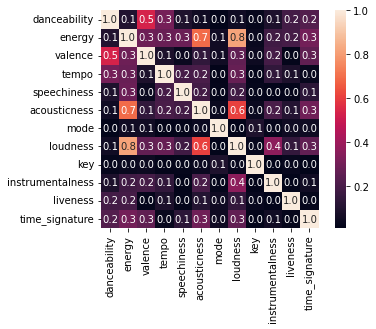

In [72]:
import seaborn as sns

sns.heatmap(abs(raw.corr()), annot=True, robust=True, square=True, fmt='.1f')

Well... I've lost a lot of my analyses but long story short, I did the following

 1. test with all features -> too noisy
 2. investigated the utility of PCA (not very, considering not much correlation, see above)
 3. considered an exhaustive search... not smart considering 4000 combinations
 4. banged my head against a wall a bit
 5. decided to do some research and live off of other people's works

In the end, I came across this paper: HOW DOES THE SPOTIFY API COMPARE TO THE MUSIC EMOTION RECOGNITION STATE-OF-THE-ART? (2021)
by Panda et. al

First off, love the main author's name. <br>
<br>
Second off, 
To summarise the paper, they had a dataset of ~900 songs that were human-tagged along the Russel's quadrant of emotions. Long story short, they were tagged for emotion.
Then they performed clustering using Spotify features (and their own) and tested for good features via ReliefF.

Their analysis points towards the four most influential features being: energy, valence, acousticness and mode.
<t>however, they found that the highest performance (with a measly f-score of just above 50% (lol)) is achieved using 11 of 12 features (all but danceability).

<t><t>however however, the performance between the top 4 features is almost equal to using 11, so I'll be using those instead. The idea is 
1. reduce noise 
2. reduce calculation complexity 
3. improve explainability

Upon some trial and error, I found that [1] is a very relevant problem - at 11 features, the distinction between high and low valence is almost entirely lost (based on human ear).

Another observation is that using instrumentalness can introduce a lot of bias, since the dataset is likely to be very skewed towards many observations being low (for most people who don't listen to instrumentals). Introducing the feature therefore can do more harm than good. Therefore, I'll instead only use 3 features.

In [73]:
RETAINED_FEATURES = [
    # 'danceability',
    'energy',
    'valence',
    # 'tempo',
    # 'speechiness',
    'acousticness',
    # 'mode',
    # 'loudness',
    # 'key',
    # 'instrumentalness',
    # 'liveness',
    # 'time_signature'
]


In [85]:
# from sklearn.preprocessing import MinMaxScaler as Scaler

scaled = raw[RETAINED_FEATURES].copy(deep=True)
# scaled[:]  = Scaler().fit_transform(scaled)


# features already scaled [0,1]. Using another scaler (such as robust) lead to bias issues from skewed data

In [86]:
from plotly.express import violin

violin(scaled)

### 2. Outlier Detection

Before coming across that paper, I dabbled a bit with outlier detection. The idea was pretty much that to help the clustering algorithm not have to deal with outliers, I just isolate them before hand, cluster the inliers, then throw all the outliers into one playlist on their own.

Two issues with this:
 1. the outliers playlist would get huge
 2. same issue with using purely statistical methods - it was removing songs that I as the human could categorise

Basically, after limiting the features to the four selected, this ended up doing more harm than good.

In [87]:
# from sklearn.neighbors import NearestNeighbors
# from numpy import sort
# from matplotlib import pyplot as plt


# neigh = NearestNeighbors(n_neighbors=2)
# nbrs = neigh.fit(scaled)
# distances, indices = nbrs.kneighbors(scaled)

# distances = sort(distances, axis=0)
# distances = distances[:, 1]

In [88]:
# from kneebow.rotor import Rotor
# from numpy import stack, arange

# rotor = Rotor()
# rotor.fit_rotate(stack((arange(1, len(distances)+1), distances), axis=1))

# elbow_idx = rotor.get_elbow_index()
# elbow_val = distances[elbow_idx]
# print(elbow_idx, elbow_val)

# rotor.plot_elbow()

In [89]:
# from sklearn.cluster import DBSCAN

# dbscan = DBSCAN(
#     eps=elbow_val
# )

# clusters = dbscan.fit_predict(scaled)


# scaled['cluster'] = clusters

In [90]:
# # isolate outliers before performing clustering

# is_outlier = scaled['cluster'] == -1


# outliers = scaled[is_outlier].copy()
# inliers = scaled[~is_outlier].copy()

### 3. Model Selection


The long and short of it, basing off the flowchart shown at the end of this blog post<br>
* https://medium.com/grabngoinfo/4-clustering-model-algorithms-in-python-and-which-is-the-best-7f3431a6e624 (behind a paywall, thanks medium)
* https://youtu.be/K_KibNSH1_0?t=753 (in video format, and free!)


Following this, we land on GMM or Hierarchal. (elliptoid, imbalanced density)

I did not test DBSCAN extensively since I cannot define N_CLUSTERS (often it would create either too many or too little clusters).
I did test Spectral Clustering though.
<br>
<br>

In [95]:
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from numpy import bincount

# for huge datasets, 4 is probably better (trying to match Russel's 4 quadrants). But for sparser datasets, you end up getting two very similar clusters.
N_CLUSTERS = 3

final = scaled.copy(deep=True)

spectral = lambda: SpectralClustering(
    n_clusters=N_CLUSTERS
)

agglo = lambda: AgglomerativeClustering(
    n_clusters=N_CLUSTERS,
    linkage='ward',
    compute_full_tree=True
)

kmeans = lambda: KMeans(
    n_clusters=N_CLUSTERS
)

gmm = lambda: GaussianMixture(
    n_components=N_CLUSTERS,
    n_init=15
)

name_model_map = {
    'spect': spectral,
    'agglo': agglo,
    'kmean': kmeans,
    # 'mixed': gmm
}


for model_name, model_l in name_model_map.items():
    model = model_l()
    final[model_name] = model.fit_predict(final[RETAINED_FEATURES])

    print('\n', model_name, model.fit_predict)
    for i, s in enumerate(bincount(final[model_name])):
        print(f'cluster {i}: {s}')


final['track_name'] = raw['track_name']


 spect <bound method SpectralClustering.fit_predict of SpectralClustering(n_clusters=3)>
cluster 0: 244
cluster 1: 173
cluster 2: 43

 agglo <bound method AgglomerativeClustering.fit_predict of AgglomerativeClustering(compute_full_tree=True, n_clusters=3)>
cluster 0: 157
cluster 1: 46
cluster 2: 257

 kmean <bound method KMeans.fit_predict of KMeans(n_clusters=3)>
cluster 0: 183
cluster 1: 61
cluster 2: 216


### 4. Results Analysis

In [96]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

to_be_plotted = final

x, y, z = 'energy', 'valence', 'acousticness'


fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
fig.update_layout(
    height=700,
    width=750,
    scene=dict(
        xaxis=dict(title=x),
        yaxis=dict(title=y),
        zaxis=dict(title=z)
    )
)

for model_name in name_model_map.keys():
    to_be_plotted['text'] = 'track: ' + to_be_plotted['track_name'].astype(str) + '<br>cluster: ' + to_be_plotted[model_name].astype(str)

    fig.add_trace(
        go.Scatter3d(
            name=model_name,
            x=to_be_plotted[x],
            y=to_be_plotted[y],
            z=to_be_plotted[z],
            text=to_be_plotted['text'],
            mode='markers',
            marker=dict(
                size=3,
                color=to_be_plotted[model_name],
                colorscale='portland',
                opacity=0.8
            ),
            hovertemplate=f"""%{{text}}<br>{x}: %{{x:.1f}}<br>{y}: %{{y:.1f}}<br>{z}: %{{z:.1f}}""",
            visible='legendonly'
        )
    )


fig.show()

Verdict:

1. GMM sucks - often ignores valence completely.
2. Spectral, Agglo and KMeans are all very similar.
3. Agglo can sometimes make very lopsided clusters in dense areas.
4. Spectral sometimes ignores valence as well.


While I would like to conclude with "I will therefore use k-means", though I must admit that it's more of a "by process of elimination" decision. 

### 5. Export Result

In [97]:
from pickle import dump

CLUSTERED_IDS = '../data/clustered_ids.bin'

selected_model = 'kmean'

with open(CLUSTERED_IDS, 'wb') as f:
    dump(final.groupby(selected_model).apply(lambda x: x.index.tolist()).to_dict(), f)
